In [78]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
#import scipy.stats as stats
import scipy.stats as stats
from scipy.stats import norm, chi2_contingency, shapiro, poisson, chisquare, expon, kstest

from statsmodels.stats.proportion import proportions_ztest

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Fase 4: Problema de A/B Testing.

El objetivo de esta fase es determinar si existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados, y si es así, cuál es la magnitud de esa relación. Partiremos de la siguiente hipótesis, "Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa. Se sospecha que los empleados con niveles de satisfacción más bajos tienen una mayor probabilidad de dejar la empresa". Para ello deberéis crear una columna nueva en base al nivel de satisfacción en el trabajo para crear dos grupos, las condiciones para crear los grupos son:

- **Grupo A (Control):** Empleados con un nivel de satisfacción en el trabajo igual o superior a 3 en una escala de 1 a 5.

- **Grupo B (Variante):** Empleados con un nivel de satisfacción en el trabajo inferior a 3 en la misma escala.

La **métrica principal** que debes usar es la tasa de rotación de empleados (Attrition) en cada grupo. Recordemos que, en esta columna, "No" indica que el empleado no ha dejado la empresa (sin rotación), mientras que "Yes" indica que el empleado ha dejado la empresa (con rotación).

Por lo tanto, los pasos que deberás seguir en esta fase son:

1. Divide a los empleados en los grupos A y B según los criterios establecidos.

2. Calcula la tasa de rotación (porcentaje de empleados que dejaron la empresa) en cada grupo.

3. Realiza un análisis estadístico para determinar si hay una diferencia significativa en la tasa de rotación entre los grupos A y B.

4. Analiza los resultados.

5. Calcular la magnitud de esta relación utilizando estadísticas como la diferencia de medias por ejemplo.

In [40]:
# lo primero que hacemos es cargar el dataframe que vamos a usar para esta lección
df = pd.read_csv("df_imputada.csv")
df.head(2)

,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,DateBirth,RemoteWork,PerformanceRating,TotalWorkingYears,MonthlyIncome
0,no,unknown,684.0,6,3,unknown,"162,0",1,female,51.0,3,5,research_director,3,unknown,6462,7,no,13,3,0,5,3.0,20,15,15,1972,yes,3.0,32.595028,19537.0
1,no,unknown,699.0,1,4,life_sciences,"259,0",3,female,65.0,2,5,manager,3,unknown,5678,0,unknown,14,1,1,5,3.0,33,11,9,1971,yes,3.0,34.000000,19999.0


In [41]:
df['JobSatisfaction'].unique()

array([3, 4, 1, 2])

In [42]:
df.columns


Index(['Attrition', 'BusinessTravel', 'DailyRate', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'DateBirth', 'RemoteWork', 'PerformanceRating',
       'TotalWorkingYears', 'MonthlyIncome'],
      dtype='object')

1. Divide a los empleados en los grupos A y B según los criterios establecidos.

In [43]:
def agrupar(valor):
    if valor >= 3:
        return "grupo_A"
    else:
        return "grupo_B"

df["GroupJobSatisfaction"]= df["JobSatisfaction"].apply(agrupar)

2. Calcula la tasa de rotación (porcentaje de empleados que dejaron la empresa) en cada grupo.

In [83]:
# calculamos la Tasa de Rotación

# Dividir los empleados en los grupos A y B
df_grupo_a = df[df['JobSatisfaction'] >= 3]
df_grupo_b = df[df['JobSatisfaction'] < 3]

# Calcular la tasa de rotación en cada grupo
tasa_rotacion_a = df_grupo_a['Attrition'].value_counts(normalize=True).get('yes', 0)
tasa_rotacion_b = df_grupo_b['Attrition'].value_counts(normalize=True).get('yes', 0)
# Empleamos normalize=True para obtener directamente la tasa en términos porcentuales
# Devuelve 0 si no hay empleados que dejaron la empresa
# Multiplicamos por 100 para obtener la tasa en porcentaje

print(f"Tasa de rotación en el Grupo A (Control) es: {tasa_rotacion_a * 100:.2f}%")
print(f"Tasa de rotación en el Grupo B (Variante) es: {tasa_rotacion_b * 100:.2f}%")
# Multiplicamos por 100 para obtener la tasa en porcentaje
# Formateamos a número flotante con 2 decimales

Tasa de rotación en el Grupo A (Control) es: 13.67%
Tasa de rotación en el Grupo B (Variante) es: 19.87%


3. Realiza un análisis estadístico para determinar si hay una diferencia significativa en la tasa de rotación entre los grupos A y B.

Dado que estamos comparando proporciones (porcentaje de empleados que dejaron la empresa) entre dos grupos independientes, una prueba chi-cuadrado de independencia o una prueba z para dos proporciones puede ser apropiada.


### Prueba de proporciones

**Interpretación:**

- Si `p_value < 0.05`: Rechazamos la hipótesis nula. Hay evidencia suficiente para decir que hay una diferencia significativa entre las dos muestras.

- Si `p_value >= 0.05`: No hay evidencia suficiente para rechazar la hipótesis nula. No podemos afirmar que haya una diferencia significativa entre las dos muestras.

In [81]:
tasa_grupo_a_rotacion=np.round(df_grupo_a[df_grupo_a["Attrition"]== "yes"].shape[0]/df_grupo_a.shape[0],2)
tasa_grupo_a_rotacion

0.14

In [107]:
# Tasa rotación grupo A (de control)
print(f"Tasa de rotación en el Grupo A (Control) es: {tasa_rotacion_a * 100:.2f}%")

# Tasa rotación grupo B (de prueba)
print(f"Tasa de rotación en el Grupo B (Variante) es: {tasa_rotacion_b * 100:.2f}%")

# Creamos un DataFrame
data_p = {
    'Grupo': ["Alta satisfaccion", "Baja satisfaccion"],
    'Rotacion': [tasa_rotacion_a,tasa_rotacion_b],
    'NoRotacion': [df_grupo_a['Attrition'].value_counts(normalize=True).get('no', 0),df_grupo_b['Attrition'].value_counts(normalize=True).get('no', 0)]
    }

df_p = pd.DataFrame(data_p)
df_p.head()

Tasa de rotación en el Grupo A (Control) es: 13.67%
Tasa de rotación en el Grupo B (Variante) es: 19.87%


,Grupo,Rotacion,NoRotacion
0,Alta satisfaccion,0.136683,0.863317
1,Baja satisfaccion,0.198708,0.801292


Text(0.5, 1.0, 'No rotacion')

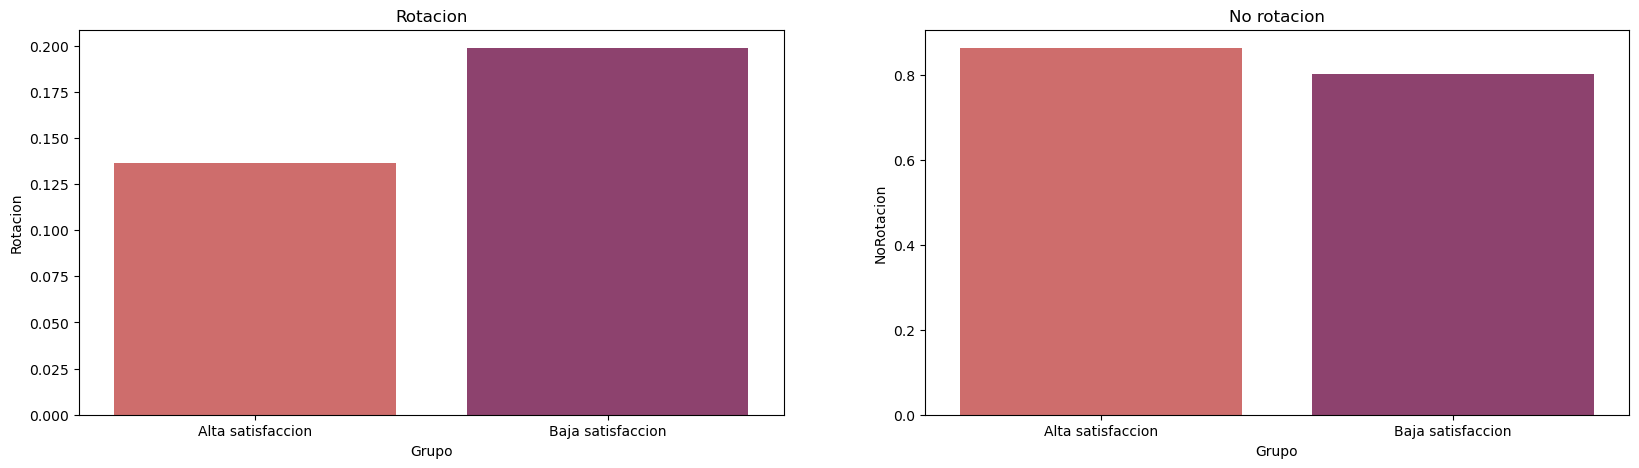

In [113]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

sns.barplot(x="Grupo", y="Rotacion", data=df_p,  palette = "flare", ax = axes[0])
sns.barplot(x="Grupo", y="NoRotacion", data=df_p,  palette = "flare", ax = axes[1])

axes[0].set_title("Rotacion")
axes[1].set_title("No rotacion")

In [114]:
# Crear una tabla de contingencia
contingency_table = pd.crosstab(df_p['Grupo'], df_p['Rotacion'])

# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print("Hay una diferencia significativa en las tasas de rotacion entre el Grupo de A (de control) y el Grupo B (de prueba).")
    print("Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas.")
else:
    print("No hay evidencia de una diferencia significativa en las tasas de rotación entre los grupos.")
    print("Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas.")

No hay evidencia de una diferencia significativa en las tasas de rotación entre los grupos.
Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas


### Prueba Z

- **Hipótesis Nula (H0):** No hay diferencia significativa en la rotación entre el grupo de control y el grupo de prueba.

- **Hipótesis Alternativa (H1):** Hay una diferencia significativa en la rotación entre el grupo de control y el grupo de prueba.

**Interpretación:**

- Si `p_value < 0.05`: Rechazamos la hipótesis nula. Hay evidencia suficiente para decir que hay una diferencia significativa entre las dos muestras.

- Si `p_value >= 0.05`: No hay evidencia suficiente para rechazar la hipótesis nula. No podemos afirmar que haya una diferencia significativa entre las dos muestras.

In [76]:
# Creamos un diccionario con dos columnas, la del grupo al que pertecen y otra con los valores de rotación
data_z = {'GroupJobSatisfaction': ['grupo_A'] * 1000 + ['grupo_B'] * 1000,
        'Attrition': np.concatenate([np.random.normal(5, 1, 1000),
                                              np.random.normal(6, 1, 1000)])}
df_z = pd.DataFrame(data_z)
df_z.head()

,GroupJobSatisfaction,Attrition
0,grupo_A,3.168906
1,grupo_A,3.665602
2,grupo_A,5.104435
3,grupo_A,4.899686
4,grupo_A,4.224052


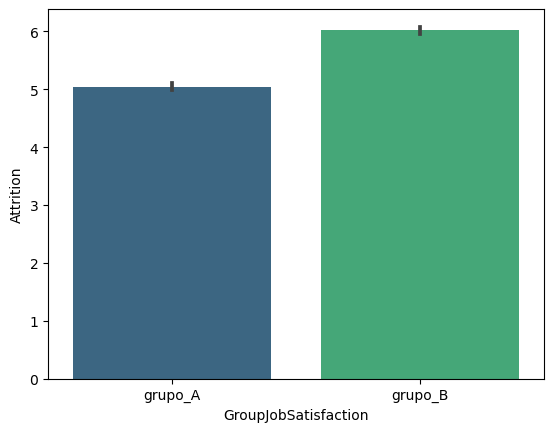

In [53]:
# Analizamos los datos primero visualmente
sns.barplot(x="GroupJobSatisfaction", y="Attrition", data=df_z,  palette = "viridis");

In [60]:
# Calcular la media y la desviación estándar del grupo A (control)
media_a_z = df_z[df_z['GroupJobSatisfaction'] == 'grupo_A']['Attrition'].mean()
std_a_z = df_z[df_z['GroupJobSatisfaction'] == 'grupo_A']['Attrition'].std()

# Calcular la media y la desviación estándar del grupo B (prueba)
media_b_z = df_z[df_z['GroupJobSatisfaction'] == 'grupo_B']['Attrition'].mean()
std_b_z = df_z[df_z['GroupJobSatisfaction'] == 'grupo_B']['Attrition'].std()

# Calcular la cantidad de datos que tenemos en el grupo A (control) y el test B (prueba)
n_a_z = len(df_z[df_z['GroupJobSatisfaction'] == 'grupo_A'])
n_b_z = len(df_z[df_z['GroupJobSatisfaction'] == 'grupo_B'])

# calcular el valor de la z
z_stat = (media_b_z - media_a_z) / np.sqrt((std_a_z**2 / n_a_z) + (std_b_z**2 / n_b_z))

# Calcular el valor p
p_value = 2 * (1 - norm.cdf(np.abs(z_stat)))

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print("Hay una diferencia significativa en la rotación entre el grupo A (de control) y el grupo B (de prueba).")
    print("Los resultados sugieren que sí que existe una diferencia entre los grupos en la rotación.")
else:
    print("No hay evidencia de una diferencia significativa en la rotación entre los grupos.")
    print("Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas.")


Hay una diferencia significativa en la rotación entre el grupo A (de control) y el grupo B (de prueba).
Los resultados sugieren que sí que existe una diferencia entre los grupos en la rotación.
